# Social Graphs: Explainer Notebook

In [2]:
import pandas as pd
import json
import urllib
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#from fa2 import ForceAtlas2


## Extracting characters from Avatar: The Last Airbender fandom wiki

In [111]:
data = pd.DataFrame({'name': [], 'nationality': []})

In [112]:
url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Characters&cmlimit=500&prop=revisions&rvprop=content&rvslots=*'
base_url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:'
page_titles = ['Water_Tribe_characters', 'Earth_Kingdom_characters', 'Fire_Nation_characters', 'Air_Nation_characters', 'United_Republic_characters', 'Characters']
character_nationalities = ['Water Tribe', 'Earth Kingdom', 'Fire Nation', 'Air Nation', 'United Republic', None]
end_url = '&cmlimit=500&prop=revisions&rvprop=content&rvslots=*&format=json'

for page_title, character_nationality in zip(page_titles, character_nationalities):
    url = base_url + page_title + end_url
    response = urllib.request.urlopen(url)
    page = json.load(response)
    category_members = page['query']['categorymembers']
    
    # Extract page title and character nationality.
    character_names = [item['title'] for item in category_members] 
    
    # Some pages may be longer than 500 members.
    if 'continue' in page.keys():
        cmcont = page['continue']['cmcontinue']
        url = base_url + page_title + end_url + '&cmcontinue=' + cmcont
        response = urllib.request.urlopen(url)
        page = json.load(response)
        category_members = page['query']['categorymembers']
        character_names += [item['title'] for item in category_members] 
        
    
    # Some Category:* items will be included. These are not important, so we can discard them.
    # We also don't want any characters from games or pilot episodes.
    filtered = filter(lambda title: 'Category:' not in title and 'pilot' not in title and 'games' not in title, character_names)
    character_names = list(filtered)

    # Might as well get nationality here.
    name_and_type = {'name': character_names, 'nationality': [character_nationality for _ in character_names]}

    # Merge with existing data frame.
    df = pd.DataFrame.from_dict(name_and_type)
    data = data.append(df)

    
# A few characters can get included multiple times.
data = data.drop_duplicates(subset='name')

# Some entries might have duplicate indices
data = data.reset_index(drop=True)

data.head(10)


name  nationality
0            Amak  Water Tribe
1            Amon  Water Tribe
2          Arnook  Water Tribe
3          Ashuna  Water Tribe
4           Atuat  Water Tribe
5            Bato  Water Tribe
6  Desna and Eska  Water Tribe
7             Due  Water Tribe
8           Gilak  Water Tribe
9            Hahn  Water Tribe

In [113]:
data.shape

(572, 2)

## Downloading character pages

In [75]:
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=revisions&rvprop=content&rvslots=*&format=json'

for character_name in data['name'].to_numpy():
    # Create URL
    print(character_name)
    original_name = character_name
    page_title = character_name.replace(' ', '_')
    
    disambig_page = False
    while True:
        disambig_page = False
        url = base_url + urllib.parse.quote_plus(page_title) + end_url
        
        # Parse response
        response = urllib.request.urlopen(url)
        page = json.load(response)
        pid = list(page['query']['pages'].keys())[0]
        page_content = page['query']['pages'][pid]['revisions'][0]['slots']['main']['*']

        # Some characters will refer to disambiguation pages, which we don't want.
        if re.findall(r'{{Disambig}}', page_content):
            print('Disambig page')
            disambig_page = True
            break
        
        # Sometimes we may be redirected. In that case, receive the redirection title and go again.
        redirect_match = re.findall(r'#REDIRECT \[\[(.*?)\]\]', page_content)
        if not redirect_match and not disambig_page:
            break
        print('Redirect, going again')
        character_name = redirect_match[0]
        page_title = character_name.replace(' ', '_')

        
    if re.findall(r'#REDIRECT', page_content):
        raise Exception
    
    # Save to file
    with open('characters/' + original_name.replace('/', '-') + '.txt', 'w') as file:
        file.write(page_content)

Amak
Amon
Arnook
Ashuna
Atuat
Bato
Desna and Eska
Due
Gilak
Hahn
Hakoda
Hama
Hiryu
Hotah
Huu
Iknik Blackstone Varrick
Kam
Kanna
Katara
Kinto
Kirima
Korra
Kuruk
Kya
Kya (nonbender)
La
Lirin
Malina
Maliq
Naga
Nini
Niyok
Noa
Nutha
Pakku
Rafa and Misu
Roku's waterbending master
Sangok
Senna
Siku and Sura
Slim
Sokka
Southern Water Tribe boy
Southern Water Tribe girl
Tarrlok
Tho
Thod
Thod's disciples
Tonraq
Tui
Ummi
Unalaq
Visola
Wei
White Lotus leader
Fanon:The Winter Moon
Yagoda
Yakone
Yakone's wife
Yue
46th Earth King
Aiwei
Animal control officer
Aoma
Arik
Ba Sing Se airship captain
Ba Sing Se University student
Baatar
Baatar Jr.
Baraz and Ahnah
Bathroom attendant
The Big Bad Hippo
Biyu
Bosco
The Boulder
Broadsword man
Bumi (King of Omashu)
Bumi's advisor
Cabbage merchant
Calm man
Canyon guide
Captured agent
Chin
Chio
Chong
Chow
Corncob guy
Dai Li sergeant
The Dark One
The Duke
Earth Empire fugitives
Earthbender captain
Earthbending academy teenagers
Farmer and wife
Feng (waitress)
Fire N

In [114]:
data.to_csv('avatar_data.csv')

In [21]:
data = pd.read_csv('avatar_data.csv')

We'll also need to download the pages as plain text for NLP.

In [43]:
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=extracts&explaintext&format=json'

for character_name in data['name'].to_numpy():
    # Create URL
    original_name = character_name
    page_title = character_name.replace(' ', '_')
    
    disambig_page = False
    while True:
        disambig_page = False
        url = base_url + urllib.parse.quote_plus(page_title) + end_url
        
        # Parse response
        response = urllib.request.urlopen(url)
        page = json.load(response)
        pid = list(page['query']['pages'].keys())[0]
        page_content = page['query']['pages'][pid]['extract']

        # Some characters will refer to disambiguation pages, which we don't want.
        if re.findall(r'{{Disambig}}', page_content):
            disambig_page = True
            break
        
        # Sometimes we may be redirected. In that case, receive the redirection title and go again.
        redirect_match = re.findall(r'#REDIRECT \[\[(.*?)\]\]', page_content)
        if not redirect_match and not disambig_page:
            break
        character_name = redirect_match[0]
        page_title = character_name.replace(' ', '_')

        
    if re.findall(r'#REDIRECT', page_content):
        raise Exception
    
    # Save to file
    with open('characters_plain_text/' + original_name.replace('/', '-') + '.txt', 'w') as file:
        file.write(page_content)

Amak
Amak was an assassin and waterbending master from the Northern Water Tribe who worked in the Earth Kingdom during the late 4th and early 3rd century BG. He eventually became the waterbending instructor of the falsely identified Avatar, Yun, though was killed during a confrontation with the Fifth Nation pirates.


== History ==


=== Serving the Avatar ===
Amak hailed from the Northern Water Tribe's capital Agna Qel'a, and was the brother of the renowned master healer Atuat. He became proficient as a hired killer, excelling in disguise, poisoning, and combat. Around 306 BG, he left his home and began working in the Earth Kingdom, where he took part in Ba Sing Se's wars of secrets and daggers. During these conspiratorial conflicts, Amak found employment for a lesser prince in Ba Sing Se. This nobleman consequently jumped from the eleventh to the fourth place in the line of succession, as several members of the Earth Kingdom's royal family unexpectedly died. Amak was eventually hired

## Extracting links and creating the GCC

It's easiest to first create all nodes in our graph and add all the according attributes.

Current attributes:
- Nationality
- Gender
- Bending style

In [7]:
gender_pat = r'\|[\s]*gender[\s]*=[\s]*(\w+)\n'

This code is used for extracting the bending style of a character. We again use the neatly organized category pages from the Avatar wiki.

In [8]:
url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Characters&cmlimit=1000&prop=revisions&rvprop=content&rvslots=*'
base_url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:'
end_url = '&cmlimit=500&prop=revisions&rvprop=content&rvslots=*&format=json'


def category_to_list(page_title):
    url = base_url + page_title + end_url
    response = urllib.request.urlopen(url)
    page = json.load(response)
    category_members = page['query']['categorymembers']
    
    # Extract page title and character nationality.
    character_names = [item['title'] for item in category_members] 
    
    # Some Category:* items will be included. These are not important, so we can discard them.
    # We also don't want any characters from games or pilot episodes.
    filtered = filter(lambda title: 'Category:' not in title and 'pilot' not in title and 'games' not in title, character_names)
    character_names = list(filtered)
    return character_names

water_benders = category_to_list('Waterbenders')
air_benders = category_to_list('Airbenders')
fire_benders = category_to_list('Firebenders')
earth_benders = category_to_list('Earthbenders')

def bending_art(name):
    if name in water_benders:
        return 'Waterbender'

    if name in earth_benders:
        return 'Earthbender'

    if name in air_benders:
        return 'Airbender'
    
    if name in fire_benders:
        return 'Firebender'
    
    return 'Non-bender'
    

In [9]:
G = nx.DiGraph()
for name, nationality in data[['name', 'nationality']].to_numpy():
    with open('characters/' + name + '.txt', 'r') as file:
        gender = None
        
        page_content = file.read()

        gender_match = re.findall(gender_pat, page_content)
        if gender_match:
            gender = gender_match[0]
        
        bending_style = bending_art(name)
        print(name, bending_style, gender)

        G.add_node(name, nationality=nationality, gender=gender, bending_art=bending_style)

Amak Waterbender Male
Amon Waterbender Male
Arnook Non-bender Male
Ashuna Non-bender Female
Atuat Waterbender Female
Bato Non-bender Male
Desna and Eska Waterbender None
Due Waterbender Male
Gilak Non-bender Male
Hahn Non-bender Male
Hakoda Non-bender Male
Hama Waterbender Female
Hiryu Waterbender Male
Hotah Non-bender Male
Huu Waterbender Male
Iknik Blackstone Varrick Non-bender Male
Kam Waterbender Male
Kanna Non-bender Female
Katara Waterbender Female
Kinto Waterbender Male
Kirima Waterbender Female
Korra Non-bender Female
Kuruk Non-bender Male
Kya Waterbender Female
Kya (nonbender) Non-bender Female
La Waterbender None
Lirin Non-bender Female
Malina Waterbender Female
Maliq Non-bender Male
Naga Non-bender Female
Nini Non-bender Female
Niyok Non-bender Female
Noa Waterbender Male
Nutha Non-bender Female
Pakku Waterbender Male
Rafa and Misu Non-bender None
Roku's waterbending master Waterbender Male
Sangok Waterbender Male
Senna Waterbender Female
Siku and Sura Waterbender Female
Sli

Now we'll extract the hyperlinks from the character pages and create the links in the network.

The Avatar wiki only uses `[[...]]` links.

In [10]:
# Patterns for detecting links
pat1 = r'\[\[(.*?)(?:#.*?)?(?:\|.*?)?\]\]'

for name in data['name'].to_numpy():
    print('Finding relations for', name)
    
    # Open the appropriate text file containing character wiki page previously saved
    with open('characters/' + name + '.txt', 'r') as file:
        page_content = file.read()

        # Convert to set to eliminate duplicates
        page_names = set(re.findall(pat1, page_content))

        for page_name in page_names:
            filtered_name = page_name.replace('+', '\+').replace('(', '\(').replace(')', '\)')
            
            # No self referencing either!
            if data['name'].str.fullmatch(filtered_name).any() and filtered_name != name:
                G.add_edge(name, page_name)

Finding relations for Amak
Finding relations for Amon
Finding relations for Arnook
Finding relations for Ashuna
Finding relations for Atuat
Finding relations for Bato
Finding relations for Desna and Eska
Finding relations for Due
Finding relations for Gilak
Finding relations for Hahn
Finding relations for Hakoda
Finding relations for Hama
Finding relations for Hiryu
Finding relations for Hotah
Finding relations for Huu
Finding relations for Iknik Blackstone Varrick
Finding relations for Kam
Finding relations for Kanna
Finding relations for Katara
Finding relations for Kinto
Finding relations for Kirima
Finding relations for Korra
Finding relations for Kuruk
Finding relations for Kya
Finding relations for Kya (nonbender)
Finding relations for La
Finding relations for Lirin
Finding relations for Malina
Finding relations for Maliq
Finding relations for Naga
Finding relations for Nini
Finding relations for Niyok
Finding relations for Noa
Finding relations for Nutha
Finding relations for Pa

With all links created, let us inspect the final graph briefly.

In [11]:
print('Number of nodes:', G.number_of_nodes())
print('Number of links:', G.number_of_edges())

Number of nodes: 453
Number of links: 4334


Let us now create the GCC. Here we hope that the GCC is not significantly smaller, as that could cause issues. We don't want a network containing very few nodes.

In [12]:
component_list = sorted(nx.weakly_connected_components(G), key=len, reverse=True)
GCC = G.subgraph(component_list[0]).copy()

And let us inspect it as before:

In [13]:
print('Number of nodes:', GCC.number_of_nodes())
print('Number of links:', GCC.number_of_edges())

Number of nodes: 452
Number of links: 4334


We find this to be a success. The GCC only contains 1 node less than the original network.

## Extracting character dialogue from The Legend of Korra episode transcripts

Sadly, we could not find a premade dataset containing character dialogue for *The Legend of Korra* as with ATLA. Therefore, we will have to do this process manually. The fandom wiki contains transcripts for each episode, which we will use for this purpose.

Our first job is finding the name, book and episode number of each episode.

In [39]:
episode_info_df = pd.DataFrame({'name': [], 'book': [], 'book_number': [], 'episode_number': [], 'series': []})

In [40]:
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=revisions&rvprop=content&rvslots=*&format=json'
page_names = ['Book_One:_Water', 'Book_Two:_Earth', 'Book_Three:_Fire', 'Book_One:_Air', 'Book_Two:_Spirits', 'Book_Three:_Change', 'Book_Four:_Balance']
books = [('Water', '1', '1'), ('Earth', '1', '2'), ('Fire', '1', '3'), ('Air', '2', '1'), ('Spirits', '2', '2'), ('Change', '2', '3'), ('Balance', '2', '4')]

episode_pat = r'\| series   = ([0-9])\s\| number   = [0-9]+\s\| name     = ([\w 0-9 \':,.]+)\s'

for page_name, (book_name, _, book_number) in zip(page_names, books):
    episode_number = 1

    # Create URL
    url = base_url + urllib.parse.quote_plus(page_name) + end_url
    
    # Parse response
    response = urllib.request.urlopen(url)
    page = json.load(response)
    pid = list(page['query']['pages'].keys())[0]
    page_content = page['query']['pages'][pid]['revisions'][0]['slots']['main']['*']
    
    episode_names = []
    book_names = []
    book_numbers = []
    episode_numbers = []
    series_numbers = []
    
    matches = re.findall(episode_pat, page_content)
    for match in matches:
        series = match[0]
        episode_name = match[1]
        
        episode_names.append(episode_name)
        book_names.append(book_name)
        book_numbers.append(book_number)
        episode_numbers.append(str(episode_number))
        series_numbers.append(series)
    
    ep_df = pd.DataFrame({'name': episode_names, 'book': book_names, 'book_number': book_numbers, 'episode_number': episode_numbers, 'series': series_numbers})
    episode_info_df = episode_info_df.append(ep_df, ignore_index=True)
    
    episode_number += 1


In [36]:
episode_info_df.to_csv('episode_info.csv')

We can now extract the actual transcript data using the dataframe above.

In [42]:
transcript_df = pd.DataFrame({'series': [], 'episode_name': [], 'book': [], 'book_number': [], 'episode_number': [], 'character_name': [], 'dialogue': []})
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=revisions&rvprop=content&rvslots=*&format=json'

transcript_pat = r'!([\w \']+)\s\|([\w .\'\[\]\-!?,\s\":]+)\s\|(?:-\s|})'
commentary_pat = r'(\[''(?:.*?)''\])'

for series, episode_name, book, book_number, episode_number in episode_info_df[['series', 'name', 'book', 'book_number', 'episode_number']].to_numpy():
    print(episode_name)
    # Edge case: some episodes are disambigiuated
    if episode_name == 'The Revelation' or episode_name == 'Harmonic Convergence':
        episode_name += ' (episode)'

    page_name = 'Transcript:' + episode_name.replace(' ', '_')
    # Create URL
    url = base_url + urllib.parse.quote_plus(page_name) + end_url
    
    # Parse response
    response = urllib.request.urlopen(url)
    page = json.load(response)
    pid = list(page['query']['pages'].keys())[0]
    page_content = page['query']['pages'][pid]['revisions'][0]['slots']['main']['*']

    character_names = []
    character_dialogues = []
    
    # Extract dialogue
    matches = re.findall(transcript_pat, page_content)
    for match in matches:
        character_name = match[0]
        character_dialogue = match[1]

        # Character dialogue also contains commentary marked in [''...'']. We want to remove this.
        commentary_matches = re.findall(commentary_pat, character_dialogue)
        for commentary_match in commentary_matches:
            character_dialogue = character_dialogue.replace(commentary_match, '')
        
        character_dialogue = ' '.join(character_dialogue.split())

        # Character names don't always match exactly when given in the transcripts. We'll just choose the closest name if available.
        character_name_match = data.name.str.extract('(' + character_name + ')', expand=False).dropna()
        if len(character_name_match) > 0:
            character_name = character_name_match.iloc[0]
            
        character_names.append(character_name)
        character_dialogues.append(character_dialogue)
    
    episode_names = [episode_name for _ in character_names]
    books = [book for _ in character_names]
    book_numbers = [book_number for _ in character_names]
    episode_numbers = [episode_number for _ in character_names]
    series_numbers = [series for _ in character_names]

    transcript_dict = {'series': series_numbers, 'episode_name': episode_names, 'book': books, 'book_number': book_numbers, 'episode_number': episode_numbers, 'character_name': character_names, 'dialogue': character_dialogues}
    transcript_df = transcript_df.append(pd.DataFrame(transcript_dict), ignore_index=True)

transcript_df.head(5)    
    
    


The Boy in the Iceberg
The Avatar Returns
The Southern Air Temple
The Warriors of Kyoshi
The King of Omashu
Imprisoned
Winter Solstice, Part 1: The Spirit World
Winter Solstice, Part 2: Avatar Roku
The Waterbending Scroll
Jet
The Great Divide
The Storm
The Blue Spirit
The Fortuneteller
Bato of the Water Tribe
The Deserter
The Northern Air Temple
The Waterbending Master
The Siege of the North, Part 1
The Siege of the North, Part 2
The Avatar State
The Cave of Two Lovers
Return to Omashu
The Swamp
Avatar Day
The Blind Bandit
Zuko Alone
The Chase
Bitter Work
The Library
The Desert
The Serpent's Pass
The Drill
City of Walls and Secrets
The Tales of Ba Sing Se
Appa's Lost Days
Lake Laogai
The Earth King
The Guru
The Crossroads of Destiny
The Awakening
The Headband
The Painted Lady
Sokka's Master
The Beach
The Avatar and the Fire Lord
The Runaway
The Puppetmaster
Nightmares and Daydreams
The Day of Black Sun, Part 1: The Invasion
The Day of Black Sun, Part 2: The Eclipse
The Western Air Temp

series            episode_name   book book_number episode_number  \
0      1  The Boy in the Iceberg  Water           1              1   
1      1  The Boy in the Iceberg  Water           1              1   
2      1  The Boy in the Iceberg  Water           1              1   
3      1  The Boy in the Iceberg  Water           1              1   
4      1  The Boy in the Iceberg  Water           1              1   

  character_name                                           dialogue  
0          Sokka  It's not getting away from me this time. Watch...  
1         Katara                                       Sokka, look!  
2         Katara                          But, Sokka! I caught one!  
3         Katara                                               Hey!  
4          Sokka  Why is it that every time ''you'' play with ma...

In [24]:
transcript_df.to_csv('atla_lok_transcript.csv')

## Stats

### Most connected characters (total degree)

In [14]:
degree_list = sorted(GCC.degree(), reverse=True, key=lambda pair: pair[1])
degree_list[:10]

[('Aang', 306),
 ('Katara', 267),
 ('Sokka', 261),
 ('Zuko', 214),
 ('Toph Beifong', 191),
 ('Korra', 123),
 ('Iroh', 121),
 ('Appa', 113),
 ('Azula', 105),
 ('Ozai', 104)]

In [15]:
out_deg = [G.out_degree(node_name) for node_name in G.nodes]
in_deg = [G.in_degree(node_name) for node_name in G.nodes]
in_out_deg = [x + y for x, y in zip(out_deg, in_deg)]

### Most connected characters (in degree)

In [16]:
in_degree_list = sorted(GCC.in_degree(), reverse=True, key=lambda pair: pair[1])
in_degree_list[:10]

[('Aang', 234),
 ('Katara', 190),
 ('Sokka', 187),
 ('Zuko', 152),
 ('Toph Beifong', 126),
 ('Iroh', 84),
 ('Korra', 81),
 ('Appa', 78),
 ('Ozai', 77),
 ('Azula', 70)]

### Most connected characters (out degree)

In [17]:
out_degree_list = sorted(GCC.out_degree(), reverse=True, key=lambda pair: pair[1])
out_degree_list[:10]

[('Katara', 77),
 ('Sokka', 74),
 ('Aang', 72),
 ('Toph Beifong', 65),
 ('Zuko', 62),
 ('Suki', 45),
 ('Tenzin', 44),
 ('Hakoda', 43),
 ('Korra', 42),
 ('Jinora', 39)]

### Average shortest path length

In [36]:
nx.average_shortest_path_length(GCC)

2.443110688146302

### Clustering coefficient

In [37]:
nx.average_clustering(GCC)

0.5857791723950487

### Degree distribution (whole network)

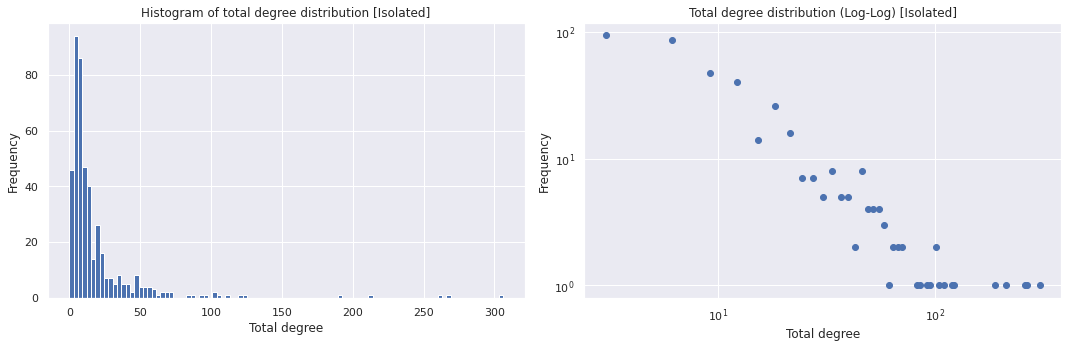

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

hist, bins = np.histogram(in_out_deg, bins=100)
axes[0].hist(bins[:-1], bins, weights=hist)
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Total degree')
axes[0].set_title('Histogram of total degree distribution [Isolated]')

hist, bins = np.histogram(in_out_deg, bins=100)
axes[1].plot(bins[:-1], hist, 'bo')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('Total degree')
axes[1].set_title('Total degree distribution (Log-Log) [Isolated]')

plt.tight_layout()
plt.show()

### Distribution of nationalities

In [19]:
nationalities = [attribs['nationality'] for _, attribs in G.nodes(data=True)]

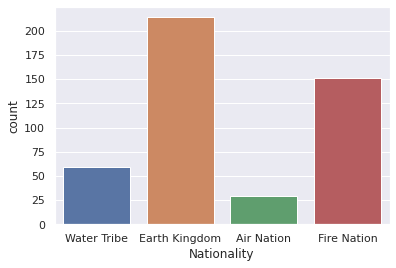

In [20]:
sns.countplot(x=nationalities)
plt.xlabel('Nationality')
plt.show()

### Distribution of gender

In [21]:
genders = [attribs['gender'] for _, attribs in G.nodes(data=True)]

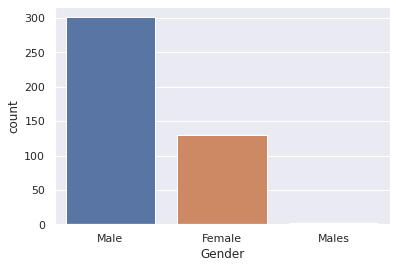

In [22]:
sns.countplot(x=genders)
plt.xlabel('Gender')
plt.show()

### Distribution of bending styles

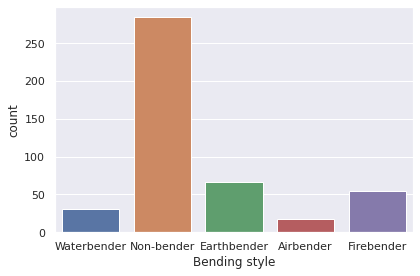

In [34]:
benders = [attribs['bending_art'] for _, attribs in G.nodes(data=True)]

sns.countplot(x=benders)
plt.xlabel('Bending style')
plt.tight_layout()
plt.show()

## Visualizing the network

We'll be using `ForceAtlas2` for finding node positions.

In [25]:
GCC_undirected = GCC.to_undirected()

Finding color of nodes based on nationality.

In [28]:
color_map = []
for node, attribs in GCC_undirected.nodes(data=True):
    if attribs['nationality'] == 'Earth Kingdom':
        color_map.append('#987654')
    elif attribs['nationality'] == 'Fire Nation':
        color_map.append('Red')
    elif attribs['nationality'] == 'Water Tribe':
        color_map.append('#00a0ff')
    elif attribs['nationality'] == 'Air Nation':
        color_map.append('#bbc6cb')

Finding node sizes based on total degree.

In [29]:
degree_dict = dict(GCC_undirected.degree)
node_sizes = [n * 10 for n in degree_dict.values()]

In [31]:
fa2_object =  ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=2,

                        # Log
                        verbose=False)


positions = fa2_object.forceatlas2_networkx_layout(GCC_undirected, pos=None, iterations=2000)

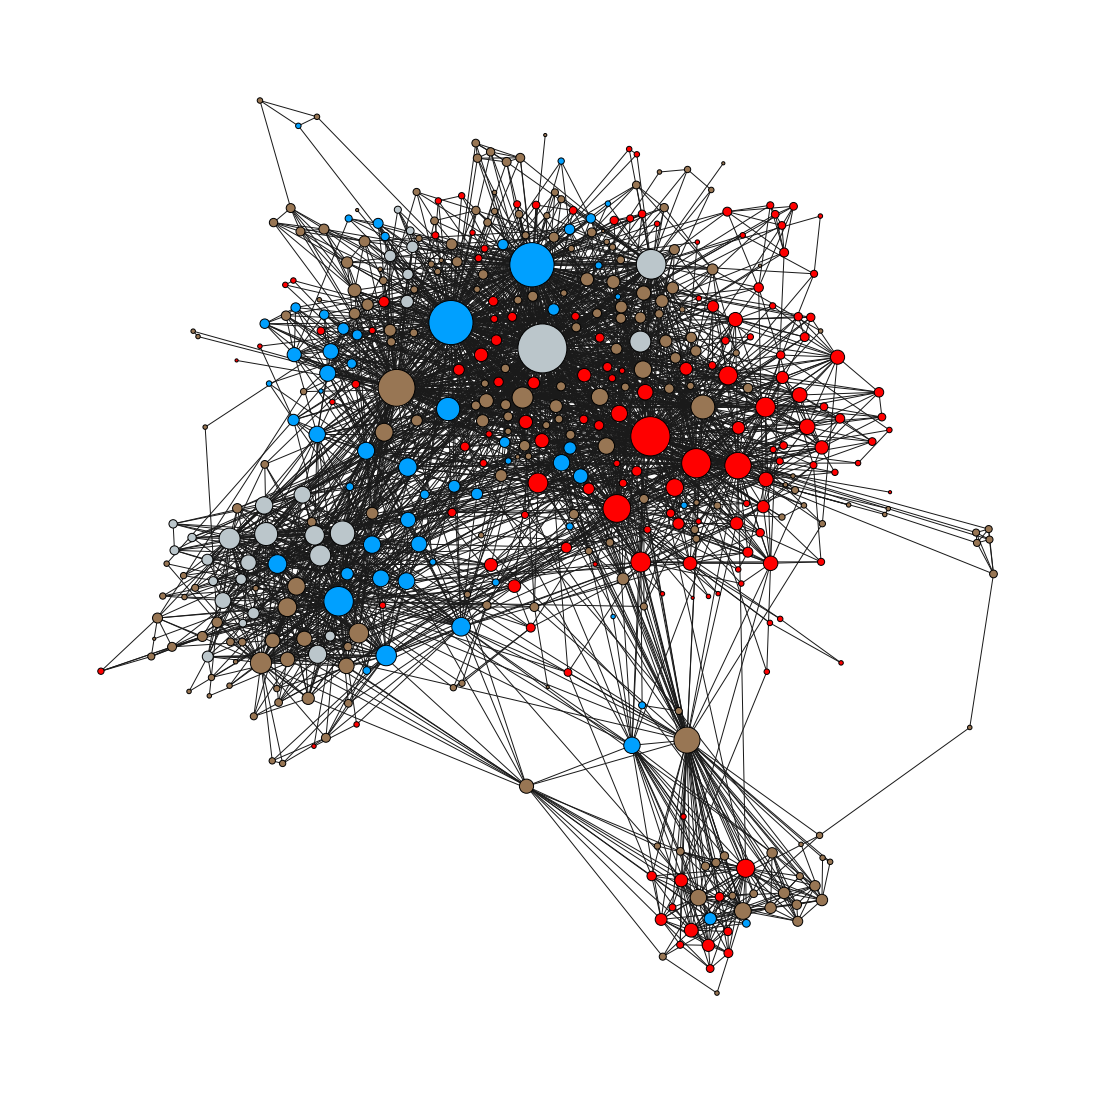

In [33]:
plt.figure(3, figsize=(15,15))
nx.draw(GCC_undirected, positions, node_color=color_map, node_size=node_sizes, edgecolors='black')
plt.show()